In [120]:
%reload_ext autoreload

In [121]:
# Packages needed

#!pip install "tabulate" "pandas_summary" "imblearn" "joblib"
#!pip install fastai==0.7.0
#!pip install eli5
#!pip install ggplot
#!pip install pdp

In [122]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline
import sys
from pandas import Timestamp
import pandas as pd
from fastai.imports import *
from fastai.structured import *
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from scipy.stats import trim_mean

#import numpy as np
#import random
#from matplotlib import pyplot
#from pandas_summary import DataFrameSummary
#from IPython.display import display
#from tabulate import tabulate
#from sklearn.model_selection import GridSearchCV
#from scipy.stats.mstats import mode, gmean, hmean
#from sklearn import metrics

#set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
sys.path.append('../lib')
import utils
import preprocessing

In [124]:
# Load in data

PATH = "../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=['canceldate', 'licence_registration_date', 'golive_date'])

In [125]:
print(len(df_raw), df_raw.shape)
print(len(df_raw.loc[(df_raw.licence_status != "STAGING") | (df_raw.plan != "CUSTOM")]), df_raw.loc[(df_raw.licence_status != "STAGING") | (df_raw.plan != "CUSTOM")].shape)

df_processed = preprocessing.prepare_data(df_raw.loc[(df_raw.licence_status != "STAGING") & (df_raw.plan != "CUSTOM")])

print(len(df_processed), df_processed.shape)

5889 (5889, 37)
5887 (5887, 37)
Sorting dataframe by licence_registration_date ...
Converting annual_revenue to a number ...
Defaulting all NaN values with median ...
Defaulting annual_revenue for missing values to the plans mean or platform medeian ...
 Platform revenue median: 62470.8
Binning last_login_days
day          4614
month+        541
few_days       99
fortnight      96
week           88
month          83
Name: last_login_categories, dtype: int64
Binning NPS data
Fixing days_active abnormal values ...
One-hot encoding customer_account_status
One-hot encoding plan
One-hot encoding nps
Preprocessing dates ...
Dropping feature customer_account_status_Good ...
Dropping feature last_login_days ...
Dropping feature account_status ...
Dropping feature changing_platform ...
Dropping feature new_platform ...
Dropping feature licence_status ...
Dropping feature canceldate ...
Dropping feature cancel_details ...
Dropping feature cancel_reason ...
Dropping feature url ...
Dropping featu

In [126]:
print(df_processed.annual_revenue[df_processed['plan_PLAN-S-19Q1'] == 1].mean())
print(trim_mean(df_processed.annual_revenue[df_processed['plan_PLAN-S-19Q1'] == 1].values, 0.1))
print(df_processed.annual_revenue.median())
utils.display_all(df_processed[df_processed.username == 'N003637'])

62826.973396946
31386.823606870228
62470.8


,username,days_active,team,vertical,salesperson,golive_days,cases_total,cases_open,cases_closed,cases_age_hours_total,cases_age_hours_average,annual_revenue,churned,cases_total_was_nan,cases_open_was_nan,cases_closed_was_nan,cases_age_hours_total_was_nan,cases_age_hours_average_was_nan,last_login_days_was_nan,plan_not_set,annual_revenue_was_missing,last_login_categories,days_active_modified,customer_account_status_PoorStanding,plan_BASIC,plan_BRONZE,plan_BUSINESS,plan_BUSINESS +,plan_BUSINESS ONE,plan_CUSTOM XL,plan_ENTERPRISE,plan_GOLD,plan_GROW,plan_L&S - PREMIUM,plan_L&S - STANDARD,plan_L&S - ULTIMATE,plan_LIST N SEND SILVER,plan_LISTNSEND,plan_NETO XL,plan_PLAN-360-17Q2,plan_PLAN-360-19Q1,plan_PLAN-360-TRANSITION,plan_PLAN-360-US,plan_PLAN-L,plan_PLAN-L-17Q2,plan_PLAN-L-19Q1,plan_PLAN-M,plan_PLAN-M-17Q2,plan_PLAN-M-19Q1,plan_PLAN-M-US,plan_PLAN-S,plan_PLAN-S-17Q2,plan_PLAN-S-19Q1,plan_PLAN-S-US,plan_PLAN-XL-19Q1,plan_PLAN-XS,plan_PLAN-XS-17Q2,plan_PREMIUM,plan_STANDARD,plan_START,plan_START - LEGACY,plan_TRIAL,plan_ULTIMATE,plan_ULTIMATE PLUS,plan_no_plan,nps_no_data,nps_detractor,nps_passive,nps_promoter,licence_registration_Year,licence_registration_Month,licence_registration_Week,licence_registration_Day,licence_registration_Dayofweek,licence_registration_Dayofyear,licence_registration_Is_month_end,licence_registration_Is_month_start,licence_registration_Is_quarter_end,licence_registration_Is_quarter_start,licence_registration_Is_year_end,licence_registration_Is_year_start,licence_registration_Elapsed,golive_Year,golive_Month,golive_Week,golive_Day,golive_Dayofweek,golive_Dayofyear,golive_Is_month_end,golive_Is_month_start,golive_Is_quarter_end,golive_Is_quarter_start,golive_Is_year_end,golive_Is_year_start,golive_Elapsed
20,N003637,2213,not specified,not specified,not specified,-1,5,0,0,1163,249,49312.96,0,1,1,1,1,1,1,0,1,day,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2013,10,40,4,4,277,False,False,False,False,False,False,1380844800,1970,1,1,1,3,1,False,True,False,True,False,True,0


In [127]:
df_filtered = df_processed

In [128]:
df_trn, y_trn, nas = proc_df(df_filtered, 'churned')
print(len(df_trn), df_trn.shape)

5521 (5521, 94)


In [129]:
def split_vals(a,n): return a[:n], a[n:]

n_valid = 500
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [130]:
X_train.shape, y_train.shape

((5021, 94), (5021,))

In [131]:
# Fix the dataset imbalance

sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [132]:
X_train_res.shape, y_train_res.shape

((5894, 94), (5894,))

In [133]:
# Show any features with NaN values
preprocessing.features_with_nan(df_filtered)

In [134]:
X_train.shape, y_train.shape

((5021, 94), (5021,))

In [135]:
m = RandomForestClassifier(
    n_estimators=2000,
    min_samples_leaf=3, 
    max_features='sqrt',
    n_jobs=-1,
    max_depth=10,
    bootstrap=False,
    criterion='entropy',
    class_weight={0: 2, 1: 1}
    )

m.fit(X_train_res, y_train_res)
#m.fit(X_train, y_train)

y_pred = m.predict(X_valid)
print(utils.uber_score(y_valid, y_pred))
utils.conf_matrix(y_valid, y_pred)

# Save to file in the current working directory
joblib_file = "churn_model.pkl"
joblib.dump(m, joblib_file)

0.5306859205776173 0.9671052631578947 0.6853146853146853 0.73 0.48193288920271393 0.27
None
tp, fn, fp, tn
[[218 130]
 [  5 147]]


['churn_model.pkl']

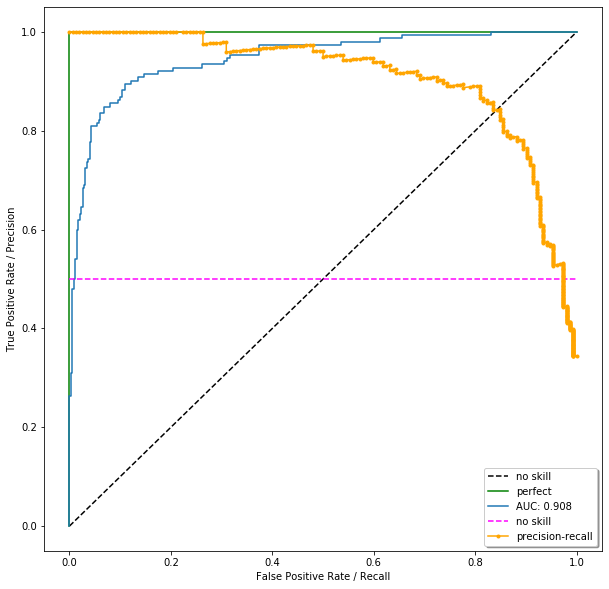

auc=0.908 ap=0.908


In [136]:
utils.plot_roc_pr(m, X_valid, y_valid)
#df_filtered.plot('golive_days', 'days_active', 'scatter', alpha=0.01, figsize=(10,8));

CPU times: user 20.1 s, sys: 2.82 s, total: 22.9 s
Wall time: 17.7 s


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c2cd530f0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c2ccc7390>})

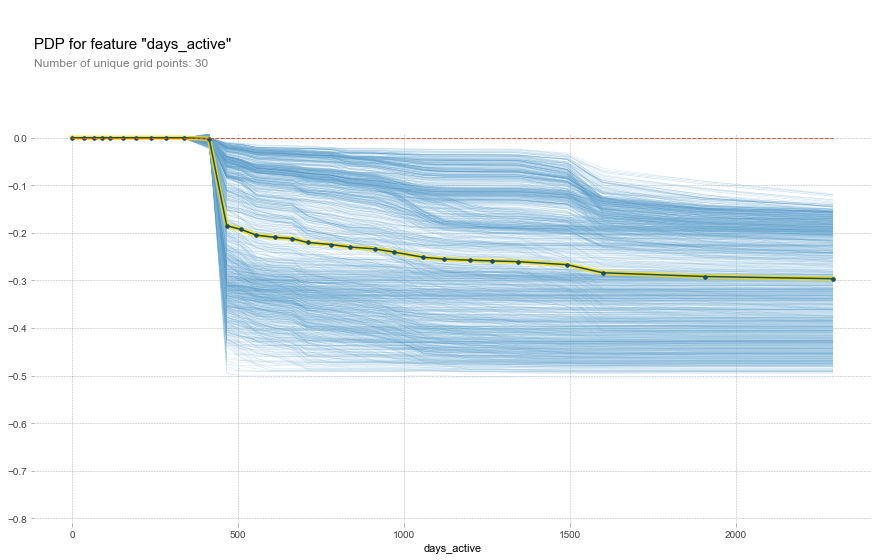

In [111]:
from pdpbox import pdp

x = get_sample(X_train, 2000)

def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feature = feat, model_features = x.columns, num_grid_points=30)
    #p = pdp.pdp_isolate(m, x, feature = feat, num_grid_points=30)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

%time plot_pdp('days_active')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c314f7240>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c335db518>})

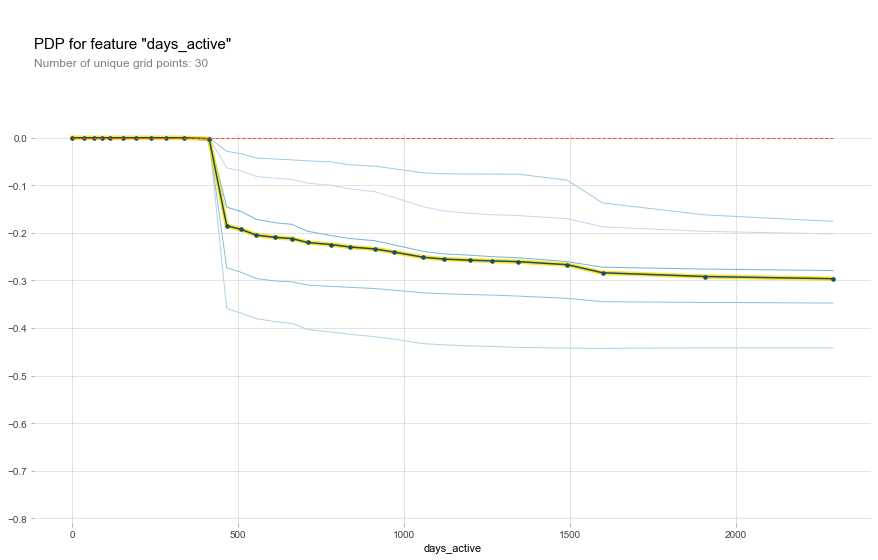

In [112]:
plot_pdp('days_active', clusters=5)

In [142]:
X_train.last_login_categories

0       1
1       1
2       1
3       2
4       1
       ..
5171    2
5172    6
5175    1
5174    1
5173    1
Name: last_login_categories, Length: 5021, dtype: int8

CPU times: user 6.79 s, sys: 630 ms, total: 7.42 s
Wall time: 6.65 s


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c2db5bdd8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c2b6767f0>})

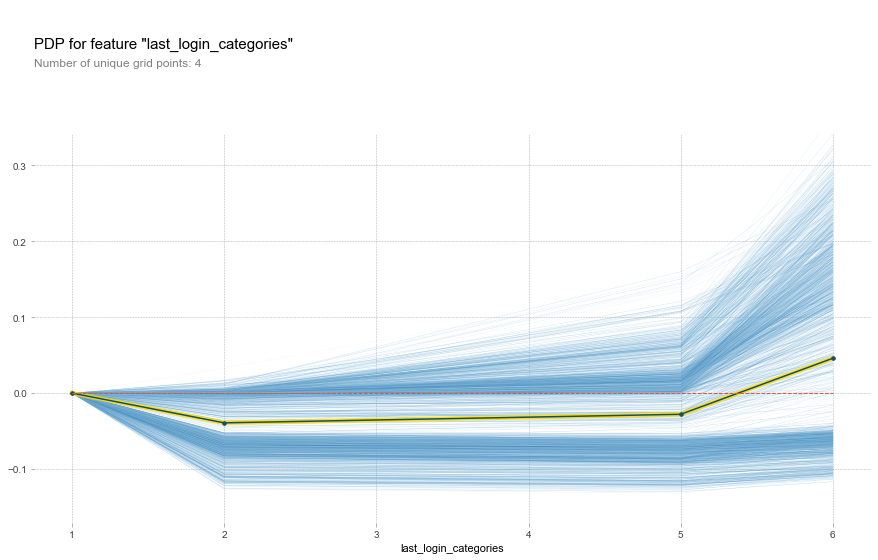

In [137]:
%time plot_pdp('last_login_categories')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c3132b080>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c312f3f60>})

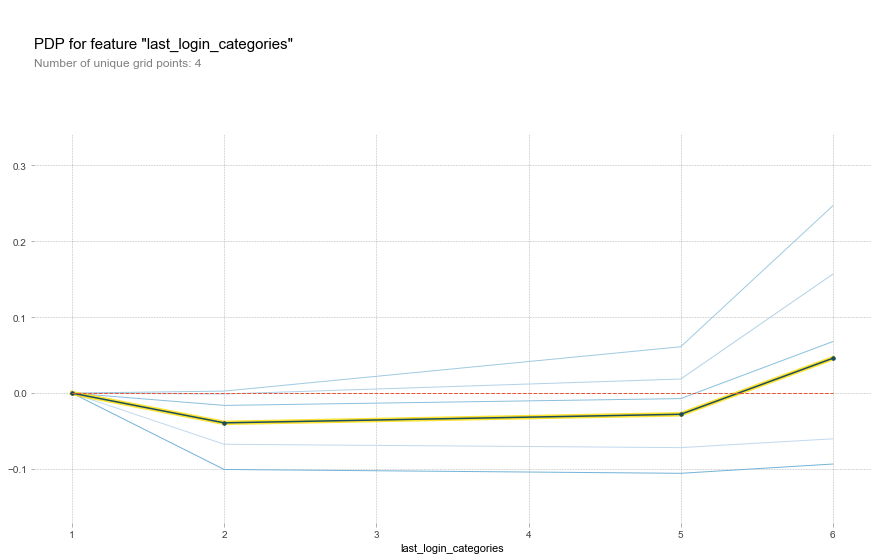

In [138]:
plot_pdp('last_login_categories', clusters=5)

In [113]:
fi = rf_feat_importance(m, X_valid); fi[:10]

,cols,imp
1,days_active,0.183951
11,annual_revenue,0.097388
9,cases_age_hours_total,0.090161
51,plan_PLAN-S-19Q1,0.085253
6,cases_total,0.076626
8,cases_closed,0.060821
7,cases_open,0.056084
20,last_login_categories,0.043410
57,plan_STANDARD,0.021781
49,plan_PLAN-S,0.021776


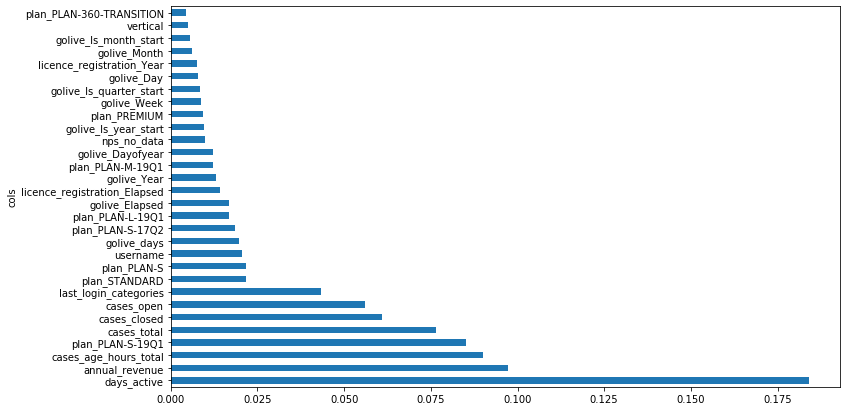

In [114]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [115]:
to_keep = fi[fi.imp>0.01].cols; len(to_keep)
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [119]:
df_keep.columns

Index(['days_active', 'annual_revenue', 'cases_age_hours_total',
       'plan_PLAN-S-19Q1', 'cases_total', 'cases_closed', 'cases_open',
       'last_login_categories', 'plan_STANDARD', 'plan_PLAN-S', 'username',
       'golive_days', 'plan_PLAN-S-17Q2', 'plan_PLAN-L-19Q1', 'golive_Elapsed',
       'licence_registration_Elapsed', 'golive_Year', 'plan_PLAN-M-19Q1',
       'golive_Dayofyear'],
      dtype='object')

In [116]:
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight={0: 2, 1: 1},
                       criterion='entropy', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=2000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

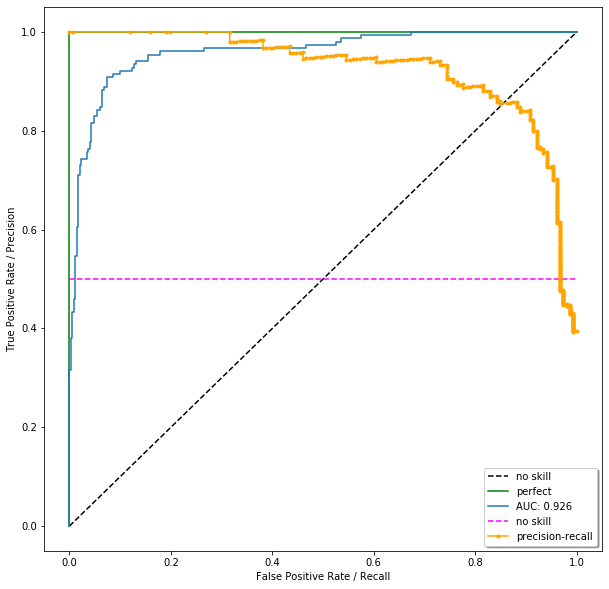

auc=0.926 ap=0.926


In [117]:
utils.plot_roc_pr(m, X_valid, y_valid)

In [118]:
# Save to file in the current working directory
#joblib_file = "churn_model.pkl"
#joblib.dump(m, joblib_file)

['churn_model.pkl']

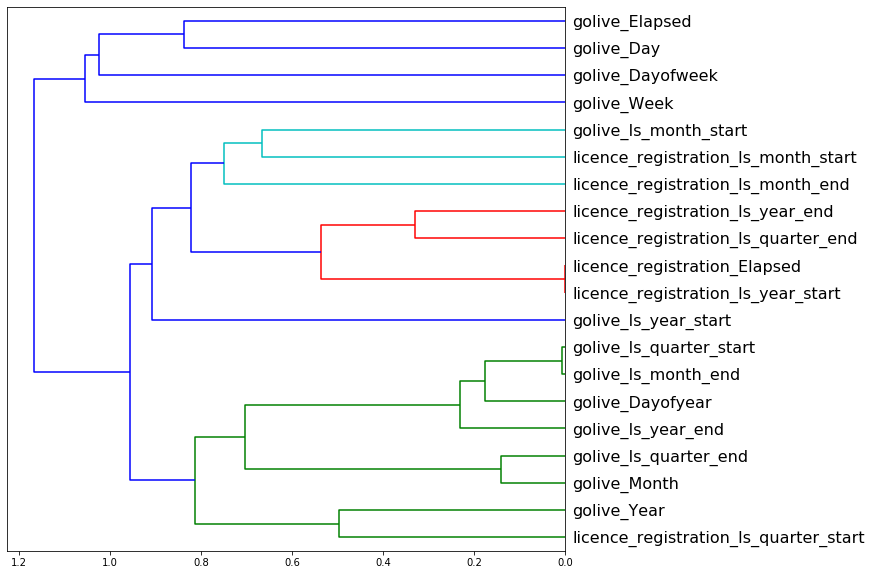

In [91]:
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(10,10))
dendrogram = hc.dendrogram(z, labels=df_trn.columns, orientation='left', leaf_font_size=16)
plt.show()

In [209]:
print("precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error")

for column in df_keep.columns:
    m = RandomForestClassifier(
        n_estimators=200,
        min_samples_leaf=2, 
        max_features='sqrt',
        n_jobs=-1, 
        max_depth=3,
        bootstrap=False,
        criterion='entropy',
        class_weight={0: 4, 1: 1}
        )

    x, _ = split_vals(df_keep.drop(columns=[column]), n_trn)
    m.fit(x, y_train)
    y_pred = m.predict(x)
    print(column, utils.uber_score(y_train, y_pred))

precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error
0.9896995708154507 0.7795807978363759 0.8721633888048411 0.8660590449772142 0.735608778995085 0.1339409550227858
days_active None
0.9968253968253968 0.7430696416497633 0.8514429595196591 0.84802853180107 0.702521755174738 0.15197146819893007
cases_closed None
0.997649271274095 0.7173766058147397 0.8346116027531957 0.8333663562512383 0.6755113253815958 0.16663364374876163
cases_total None
0.997649271274095 0.7173766058147397 0.8346116027531957 0.8333663562512383 0.6755113253815958 0.16663364374876163
annual_revenue None
0.9967166979362101 0.7183908045977011 0.8349705304518664 0.8335644937586685 0.675789469176262 0.1664355062413315
cases_age_hours_total None
0.9950383400992332 0.7457741717376606 0.8525603864734299 0.8488210818307905 0.7038358069819595 0.15117891816920942
cases_open None
0.9957845433255269 0.7187288708586883 0.8348713921068133 0.8333663562512383 0.6753387771842287 0.16663364374876163
plan_PLAN-S-19Q1